In [114]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [238]:
transform = transforms.Compose([
    transforms.Resize((256, 256)), # try smaller things as details not that important
    transforms.ToTensor()
    # transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

label_map = {
    'autumn': 0,
    'spring': 1,
    'summer': 2,
    'winter': 3
}

In color_type_clip:

- `clustered_by_color_type_manually_cleaned` was used for training
- `reference` was used for validation 
- `test` for testing

In [242]:
def images_to_tensors(path, transform):
    X = []  
    y = []  

    for label_name, label_id in label_map.items():
        folder = os.path.join(path, label_name)
        print(folder)
        if not os.path.isdir(folder):
            continue
        for filename in os.listdir(folder):
            if filename.lower().endswith((".jpg", ".jpeg", ".png")):
                new_path = os.path.join(folder, filename)
                try:
                    image = Image.open(new_path).convert("RGB")
                    image_tensor = transform(image)
                    X.append(image_tensor)
                    y.append(label_id)
                except Exception as e:
                    print(f"Error with file {new_path}: {e}")

    X = torch.stack(X)
    y = torch.tensor(y)
    return X, y

In [243]:
# Train and validation datasers load 

X_train, y_train = images_to_tensors('faces_cleaned_only_augmentated/', transform)
X_val, y_val = images_to_tensors('reference/', transform)

# from torch.utils.data import random_split, TensorDataset

# dataset = TensorDataset(X_train, y_train)
# train_size = int(0.9 * len(dataset))
# val_size = len(dataset) - train_size

# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


faces_cleaned_only_augmentated/autumn
faces_cleaned_only_augmentated/spring
faces_cleaned_only_augmentated/summer
faces_cleaned_only_augmentated/winter
reference/autumn
reference/spring
reference/summer
reference/winter


In [244]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [137]:
batch_size = 32
learning_rate = 0.001
num_epochs = 10
num_classes = 4

In [215]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), #(16,256,256)
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.MaxPool2d(2), #(16,128,128)

            nn.Conv2d(16, 32, kernel_size=3, padding=1), #(32,128,128)
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1), #(64,64,64)
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2), #(64,32,32)
            
            # nn.Conv2d(3, 32, kernel_size=3, padding=1), #(32,128,128)
            # nn.ReLU(),
            # nn.Dropout(0.3),
            # nn.Conv2d(32, 64, kernel_size=3, padding=1,stride=2), #(64,64,64)
            # nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 128),
            # nn.Linear(64 * 64 * 64, 128), 
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x
    

In [227]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

weights = torch.tensor([2.937, 7.017, 7.930, 2.558], device=device)
criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total = 0 
    correct = 0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    acc = correct / total * 100
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {acc:.2f}%")


    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_acc = correct / total * 100
    scheduler.step(val_loss)
    print(f"Epoch {epoch}: Val Loss={val_loss/len(val_loader):.4f}, Val Acc={val_acc:.2f}, LR: {optimizer.param_groups[-1]['lr']}")


100%|██████████| 120/120 [00:03<00:00, 33.03it/s]


Epoch [1/10], Loss: 164.5488, Accuracy: 37.31%
Epoch 0: Val Loss=1.3311, Val Acc=38.33, LR: 0.001


100%|██████████| 120/120 [00:03<00:00, 32.96it/s]


Epoch [2/10], Loss: 145.7694, Accuracy: 47.32%
Epoch 1: Val Loss=1.3200, Val Acc=33.33, LR: 0.001


100%|██████████| 120/120 [00:03<00:00, 33.03it/s]


Epoch [3/10], Loss: 132.4960, Accuracy: 53.33%
Epoch 2: Val Loss=1.3174, Val Acc=33.33, LR: 0.001


100%|██████████| 120/120 [00:03<00:00, 32.97it/s]


Epoch [4/10], Loss: 108.4005, Accuracy: 62.54%
Epoch 3: Val Loss=1.3170, Val Acc=32.78, LR: 0.001


100%|██████████| 120/120 [00:03<00:00, 32.95it/s]


Epoch [5/10], Loss: 81.5252, Accuracy: 71.71%
Epoch 4: Val Loss=1.3538, Val Acc=32.22, LR: 0.001


100%|██████████| 120/120 [00:03<00:00, 32.92it/s]


Epoch [6/10], Loss: 53.5842, Accuracy: 80.86%
Epoch 5: Val Loss=1.5929, Val Acc=33.89, LR: 0.001


100%|██████████| 120/120 [00:03<00:00, 33.03it/s]


Epoch [7/10], Loss: 33.6024, Accuracy: 88.50%
Epoch 6: Val Loss=1.5510, Val Acc=38.89, LR: 0.001


100%|██████████| 120/120 [00:03<00:00, 33.02it/s]


Epoch [8/10], Loss: 20.4606, Accuracy: 92.55%
Epoch 7: Val Loss=1.7609, Val Acc=30.00, LR: 0.0005


100%|██████████| 120/120 [00:03<00:00, 33.05it/s]


Epoch [9/10], Loss: 8.8207, Accuracy: 97.41%
Epoch 8: Val Loss=1.8721, Val Acc=33.33, LR: 0.0005


100%|██████████| 120/120 [00:03<00:00, 32.86it/s]

Epoch [10/10], Loss: 6.8816, Accuracy: 98.20%
Epoch 9: Val Loss=1.9280, Val Acc=33.89, LR: 0.0005


In [219]:
# Test dataset load

X = []
y = []
for filename in os.listdir('tests_cleaned_back'):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        path = os.path.join('tests', filename)
        try:
            image = Image.open(path).convert("RGB")
            image_tensor = val_transform(image)
            X.append(image_tensor)
        except Exception as e:
            print(f"Error with file {path}: {e}")

X_test = torch.stack(X)
df = pd.read_csv('true_labels.csv')
y_test = df['color_type'].map(label_map).values
y_test = torch.tensor(y_test, dtype=torch.long)

In [229]:
with torch.no_grad():
    X_test = X_test.to(device)
    outputs = model(X_test)
    _, y_pred = torch.max(outputs, 1)

In [230]:
from sklearn.metrics import classification_report

print(classification_report(y_test.cpu().numpy(), y_pred.cpu().numpy(), target_names=label_map.keys()))


              precision    recall  f1-score   support

      autumn       0.31      0.38      0.34        21
      spring       0.27      0.19      0.22        21
      summer       0.38      0.42      0.40        24
      winter       0.35      0.33      0.34        21

    accuracy                           0.33        87
   macro avg       0.33      0.33      0.33        87
weighted avg       0.33      0.33      0.33        87



In [234]:
# for validation data 

with torch.no_grad():
    X_val = X_val.to(device)
    outputs = model(X_val)
    _, y_pred = torch.max(outputs, 1)
    
print(classification_report(y_val.cpu().numpy(), y_val.cpu().numpy(), target_names=label_map.keys()))


              precision    recall  f1-score   support

      autumn       0.32      0.31      0.31        45
      spring       0.34      0.27      0.30        45
      summer       0.27      0.31      0.29        45
      winter       0.42      0.47      0.44        45

    accuracy                           0.34       180
   macro avg       0.34      0.34      0.34       180
weighted avg       0.34      0.34      0.34       180



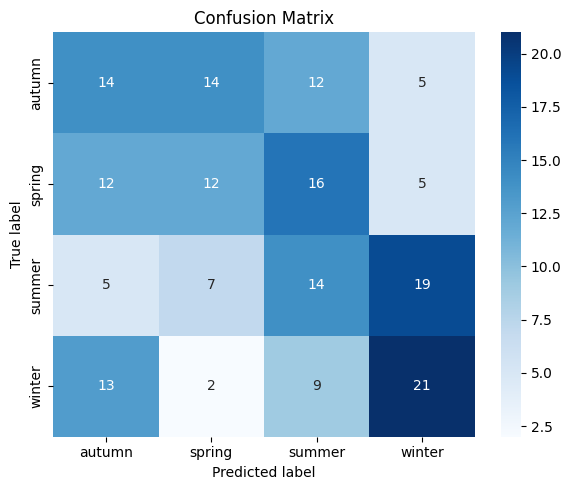

In [235]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test.cpu().numpy(), y_pred.cpu().numpy())
labels = list(label_map.keys())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

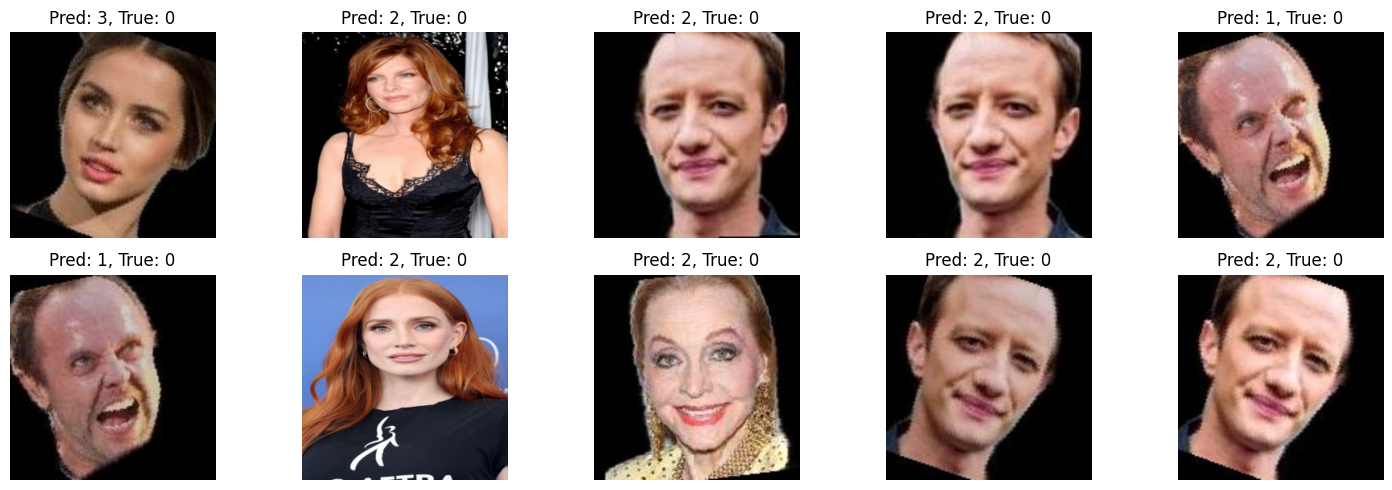

In [236]:
import matplotlib.pyplot as plt

model.eval()
wrong_images = []
wrong_preds = []
wrong_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        wrong_mask = predicted != labels
        if wrong_mask.any():
            wrong_images.append(images[wrong_mask].cpu())
            wrong_preds.extend(predicted[wrong_mask].cpu().tolist())
            wrong_labels.extend(labels[wrong_mask].cpu().tolist())

if wrong_images:
    wrong_images = torch.cat(wrong_images)

    num_display = min(10, len(wrong_images))
    plt.figure(figsize=(15, 5))
    for i in range(num_display):
        img = wrong_images[i].permute(1, 2, 0).numpy()
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(f"Pred: {wrong_preds[i]}, True: {wrong_labels[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("Error.")


In [237]:
import joblib

joblib.dump(model, 'cnn_model.pkl')

['cnn_model.pkl']